In [108]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [109]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import SmilesMolSupplier
import re

from datetime import date
import gzip
import numpy as np
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)
import pickle
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import class_weight
from termcolor import colored
from sklearn.model_selection import train_test_split
import sklearn.metrics

import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARN
import lightgbm as lgb; lgb.__version__

import pickle

'3.2.1'

In [110]:
metrics_256_df = pd.read_csv('output_with_moses/metrics_256.csv',index_col=0)
metrics_256_df.loc['mean_256'] = metrics_256_df.mean()
metrics_256_df
metrics_512_df = pd.read_csv('output_with_moses/metrics_512.csv',index_col=0)
metrics_512_df.loc['mean_512'] = metrics_512_df.mean()
metrics_512_df
metrics_1024_df = pd.read_csv('output_with_moses/metrics_1024.csv',index_col=0)
metrics_1024_df.loc['mean_1024'] = metrics_1024_df.mean()
metrics_1024_df
metrics_2048_df = pd.read_csv('output_with_moses/metrics_2048.csv',index_col=0)
metrics_2048_df.loc['mean_2048'] = metrics_2048_df.mean()
metrics_2048_df

,precision,recall,f1-score,support
0,0.926230,0.812950,0.865900,139.000000
1,0.621212,0.732143,0.672131,56.000000
2,0.629630,0.723404,0.673267,47.000000
mean_256,0.725690,0.756166,0.737100,80.666667


,precision,recall,f1-score,support
0,0.957627,0.812950,0.879377,139.000000
1,0.613333,0.821429,0.702290,56.000000
2,0.693878,0.723404,0.708333,47.000000
mean_512,0.754946,0.785927,0.763334,80.666667


,precision,recall,f1-score,support
0,0.942623,0.827338,0.881226,139.000000
1,0.671642,0.803571,0.731707,56.000000
2,0.716981,0.808511,0.760000,47.000000
mean_1024,0.777082,0.813140,0.790978,80.666667


,precision,recall,f1-score,support
0,0.958333,0.827338,0.888031,139.000000
1,0.638889,0.821429,0.718750,56.000000
2,0.720000,0.765957,0.742268,47.000000
mean_2048,0.772407,0.804908,0.783016,80.666667


In [111]:
full_df = pd.concat([metrics_256_df,metrics_512_df, metrics_1024_df, metrics_2048_df],ignore_index=True)
rows = []
r = 3
for i in range(len(full_df)):
    if i == r:
        rows.append(list(full_df.loc[i]))
        r+=4

In [112]:
means_df = pd.DataFrame(rows)
means_df.columns = ['precision', 'recall', 'f1-score', 'support']
means_df = means_df.transpose()
means_df.columns = ['256', '512', '1024', '2048']
means_df = means_df.transpose()
means_df.drop(['support'],axis=1, inplace=True)

In [113]:
means_df

,precision,recall,f1-score
256,0.725690,0.756166,0.737100
512,0.754946,0.785927,0.763334
1024,0.777082,0.813140,0.790978
2048,0.772407,0.804908,0.783016


Text(0.5, 0, 'fp bits')

Text(0, 0.5, 'value')

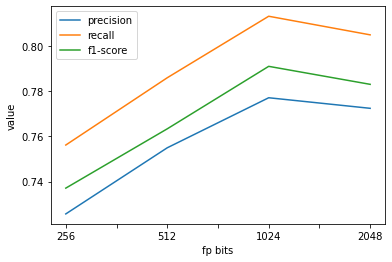

In [114]:
fig = means_df.plot.line()
fig.set_xlabel('fp bits')
fig.set_ylabel('value')

In [115]:
def predictProteinDegradation(mol, fp_bit_sz, cellType : str = "HeLa", target : str = "ER", e3Ligase : str = "IAP") -> int:
    with open(f'output_with_moses/Protac_Scoring_Model_{fp_bit_sz}.pkl', 'rb') as f1:
        scoring_model = pickle.load(f1)
    with open(f'output_with_moses/features_{fp_bit_sz}.pkl', 'rb') as f2:
        features = pickle.load(f2)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_bit_sz)
    fp_array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, fp_array)
    input = [list(0 for i in range(88)) + list(fp_array) + list(0 for i in range(161)), list(0 for i in range(505))]

    tgt_ind = features.index("tgt_"+target)
    ct_ind = features.index("ct_"+cellType)
    e3_ind = features.index("e3_"+e3Ligase)
    input[0][tgt_ind] = 1
    input[0][ct_ind] = 1
    input[0][e3_ind] = 1


    y_pred = scoring_model.predict([input[0]])
    return y_pred[0].argmax()

In [116]:
mols = SmilesMolSupplier('data/epoch_100.smi', sanitize=True, nameColumn=-1,titleLine=True)
actives = []
for fp_bit_sz in [256,512,1024,2048]:
    num_active = 0
    for m in mols:
        score = predictProteinDegradation(m,fp_bit_sz)
        if score>0:
            num_active+=1
    actives.append(num_active/len(mols))
means_df['predicted active'] = actives

In [117]:
means_df

,precision,recall,f1-score,predicted active
256,0.725690,0.756166,0.737100,0.0
512,0.754946,0.785927,0.763334,0.0
1024,0.777082,0.813140,0.790978,0.0
2048,0.772407,0.804908,0.783016,0.0
